# 추천 시스템

추천시스템은 사용자가 선호하는 상품을 예측하는 시스템

Netflix 등의 온라인 비디오 콘텐츠 제공 플랫폼에서 사용자가 그동안 시청했던 영상 기록, 평점 기록 정보등을 바탕으로 사용자가 가장 만족할만한 상품을 추천하는 시스템이 추천 시스템이다.

# Surprise 패키지

무료로 추천시스템을 만들기 위한 패키지는 Surpise이다.

그 외의 다른 좋은 성능을 보유한 패키지는 대부분 유료이다.

In [1]:
import surprise

# 평점 데이터

surprise 패키지에는 MovieLense라는 영화 추천 웹사이트의 데이터를 샘플 평점 데이터로 제공.

In [6]:
data = surprise.Dataset.load_builtin('ml-100k')
df = pd.DataFrame(data.raw_ratings, columns=['user','item','rate','id'])
del df['id']

df.head(10)

,user,item,rate
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0
5,298,474,4.0
6,115,265,2.0
7,253,465,5.0
8,305,451,3.0
9,6,86,3.0


- user : 사용자 ID
- item : 상품 ID
- rate : 평점

**추천 시스템은 결국 사용자 아이디와 상품 아이디라는 두 개의 카테고리 입력과 평점 출력을 가지는 예측 시스템**

피벗테이블 형태로 변환하면 X축이 상품, y축이 사용자 아이디인 평점 행렬 $R$이 된다.

In [7]:
df_pivot = pd.pivot_table(df, index=df.user, columns=df.item)
df_pivot.shape

(943, 1682)

행은 특정 사용자의 평점, 열은 특정 상품의 평점을 의미한다.

In [8]:
df_pivot.iloc[212:222, 808:817].fillna("")

rate                                        
item  211  212  213  214  215  216  217  218  219
user                                             
290   3.0                      4.0       2.0     
291        4.0       4.0  4.0            4.0  4.0
292                  3.0                         
293   4.0       3.0       4.0  4.0  3.0  2.0     
294                                              
295             5.0       5.0  5.0  4.0  5.0     
296   4.0                                        
297   4.0       3.0       2.0  4.0       3.0     
298   5.0       3.0       5.0                    
299   4.0  4.0  5.0            5.0

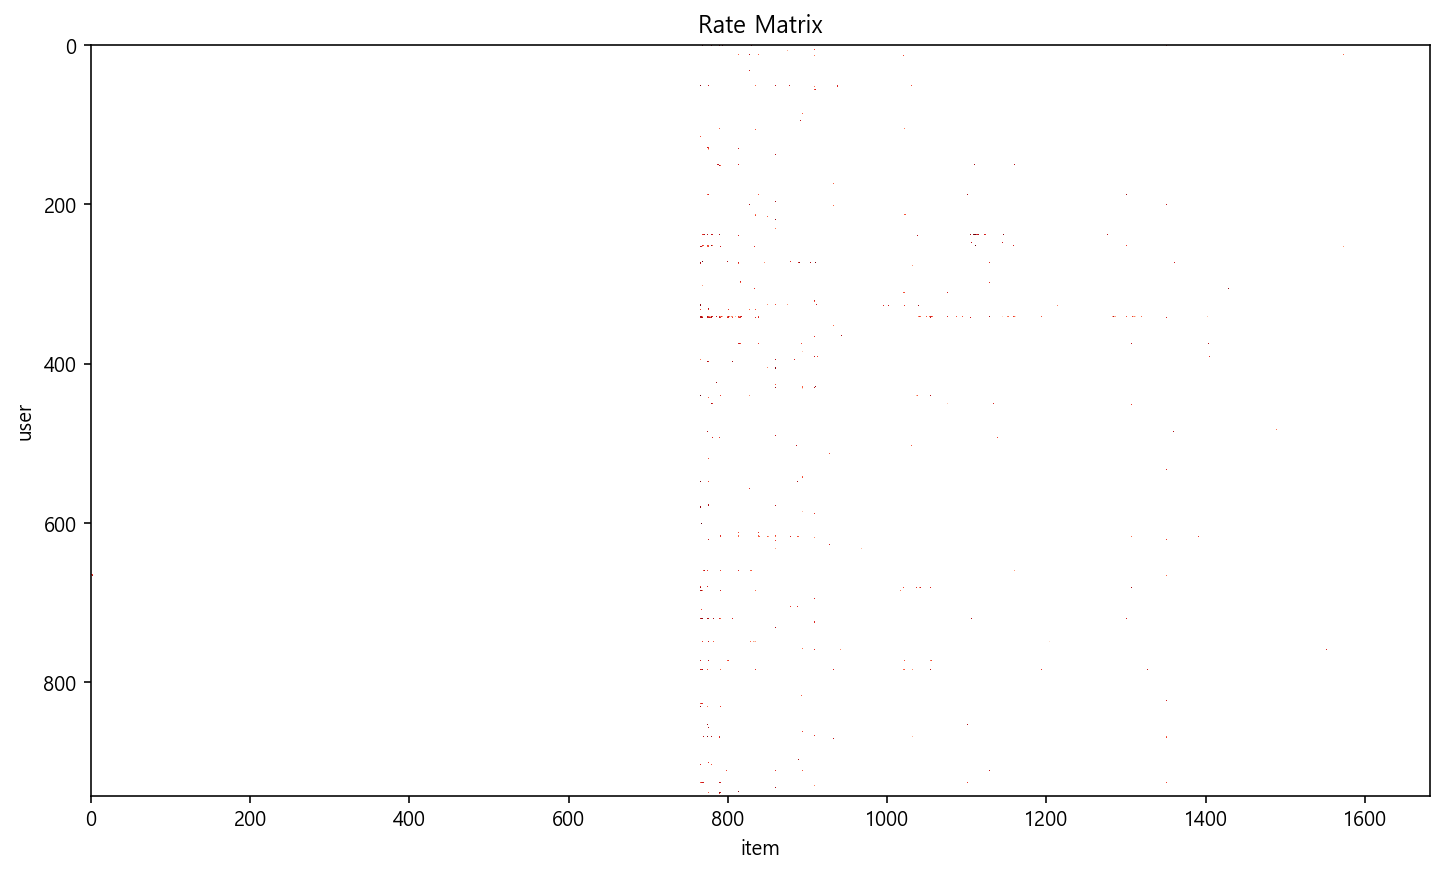

In [10]:
plt.figure(figsize=(12, 8))
plt.imshow(df_pivot, 'Reds')
plt.grid(False)
plt.xlabel("item")
plt.ylabel("user")
plt.title("Rate Matrix")
plt.show()

# 추천 시스템 알고리즘

추천 시스템은 기본적으로 두 개의 카테고리 값 입력(더미변수)에서 하나의 실수 값을 예측하는 회귀 모형이다. 이를 Baseline Model이라한다.

Baseline Model 이외에도 여러 방법으로 예측 성능을 향상시키는 다양한 모델이 존재한다.

1. Baseline Model
2. Collaborative Filtering

    1. Neighborhood Models
        - User-based CF
        - Item-based CF
    2. Latent Factor Models
        - Matrix Factorization
        - SVD
3. Content-Based Recommendation

# 베이스라인 모형

베이스라인 모형은 더미변수를 사용한 회귀분석으로 이해할 수 있다.

베이스라인 모형에서 예측값(rate)을 구하는 방식은 아래와 같다.

$$\hat{r}(u,i) = \mu + b(u) + b(i)$$

- $\mu$는 상수항을 의미한다.
- $b(u)$는 더미변수 앞에 붙는 $w$로 Bias를 의미한다.($u$번째 아이디 user앞에 붙는 $w$값)
- $b(i)$는 item을 더미변수화 했을 때 앞에 붙는 $w$를 의미한다.


이를 보다 직관적으로 예를 들어 설명하자면 $\mu$는 기본적으로 붙는 평점, $b(u)$는 특정 유저는 다른 사람들보다 어느정도의 평점을 더 주더라, $b(i)$는 특정 아이템은 다른 아이템들보다 어느정도 평점을 더 받더라 라는 의미로 이해할 수 있다.

즉, 베이스라인 모형은 기본적인 회귀 분석과 다를 것이 없다.

하지만 여기서 발생하는 문제는 데이터의 사이즈가 너무 방대하다는 것이다. 따라서 모든 데이터를 가지고 Matrix를 이용해 inverse를 구해야한다. 따라서 정상적인 방법으로는 회귀분석을 수행할 수 없다.

따라서 실제 rate와 예측한 rate와의 오차가 가능한 한 적어지도록 수치적 최적화를 통해 바로 $b$값을 찾는다.

$$\sum_{u,i \in R_{train}} \left(r(u,i) - \hat{r}(u,i))\right)^2$$

- $R_{train}$ : 실제 평점이 존재하는 학습용 데이터

바로 수치적 최적화를 진행하지만 과적합을 방지하기 위해 다음과 같은 정규화 항을 추가한다.

$$\sum_{u,i \in R_{train}} \left(r(u,i) - \hat{r}(u,i))\right)^2 + \lambda \left(b(u)^2 + b(i)^2 \right)$$

위 식은 Ridge 정규화 항을 추가한 방법이다.

surprise 패키지는 Loss function을 최소화하기 위해 다음과 같은 두가지 최적화 알고리즘을 제공한다. 이 알고리즘의 선택은 `method` 파라미터를 통해 설정한다.

- `SGD(Stochastic Gradient Descent):`
    - reg : 정규화 가중치, 디폴트 = 0.02
    - learning_rate : 최적화 스텝 사이즈, 디폴트 = 0.005
    - n_epochs : 최적화 반복 횟수, 디폴트 = 20
    

- `ALS(Alternating Least Squares):`
    - reg_i : 상품에 대한 정규화 가중치, 디폴트 = 10
    - reg_u : 사용자에 대한 정규화 가중치, 디폴트 = 15
    - n_epochs : 최적화 반복 횟수, 디폴트 = 10

# 모형 사용법

1. 데이터셋의 split, folds 메소드를 이용하여 K-Fold 트레이닝 데이터셋과 테스트셋을 생성


2. Model 알고리즘 선택


3. Model 알고리즘 객체의 train 메소드와 트레이닝 데이터셋으로 모수를 추정한 후 test 메소드로 데이터 셋에 대한 예측


4. Model 성능평가

이 과정은 evaluate 메소드로 단축이 가능하다.

# 추천시스템 Metrics

- RMSE(Root Mean Squared Error)

- MAE(Mean Absolute Error)

- FCP(Fraction of Concordant Pairs)

$$\text{FCP} = \dfrac{\text{number of concordant pairs}}{\text{number of discordant pairs}}$$

FCP의 concordant는 $i$번째 상품과 $j$번째 상품에서 실제로 $j$번째 상품의 평점이 더 좋았는데 예측 결과 역시 그러하면 concordant라 한다.

만약 위 설명에 반대되는 경우 discordant라 하며 이 둘의 비율을 이용한 모델의 성능을 정량화 한 값을 FCP라 한다.

# Baseline Model Example

In [11]:
from surprise.model_selection import KFold

# 베이스라인 모델에 사용할 파라미터 정의
bsl_options = {
    'method' : 'als',
    'n_epochs' : 5,
    'reg_u' : 12,
    'reg_i' : 5
}

# 베이스라인 모델 생성
algo = surprise.BaselineOnly(bsl_options)

np.random.seed(0)
acc = np.zeros(3)
cv = KFold(3)

# cv객체의 split메소드를 이용해 3개의 폴트와 train, test셋 사용
for i, (trainset, testset) in enumerate(cv.split(data)):
    algo.fit(trainset)
    predictions = algo.test(testset)
    acc[i] = surprise.accuracy.rmse(predictions, verbose=True)
acc.mean()

Estimating biases using als...
RMSE: 0.9453
Estimating biases using als...
RMSE: 0.9377
Estimating biases using als...
RMSE: 0.9500


0.9443304984013942

위 과정을 cross_validate 메소드를 이용해 한번에 수행할 수 있다.

In [30]:
from surprise.model_selection import cross_validate

cross_validate(algo, data)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([0.94401235, 0.93669078, 0.94714989, 0.94400004, 0.93606355]),
 'test_mae': array([0.74688773, 0.73846283, 0.75322622, 0.74843106, 0.74206187]),
 'fit_time': (0.11066722869873047,
  0.13563776016235352,
  0.14561080932617188,
  0.148634672164917,
  0.16359305381774902),
 'test_time': (0.08078289031982422,
  0.3899548053741455,
  0.07679414749145508,
  0.08274483680725098,
  0.08876419067382812)}

In [26]:
algo.bsl_options['method']

'als'

In [29]:
result['test_rmse'].mean(), result['test_mae'].mean()

(0.9411881352307816, 0.7454558447235036)

# Collaborative Filter

추천 시스템을 만든다는 것은 앞서 살펴본 rate matrix의 결측치들을 imputation하겠다는 것으로 이해할 수 있다.

이처럼 Collaborative Filter 방법은 회귀분석을 이용하는 것이 아닌 rate matrix가 가지는 특정한 패턴을 이용해 이를 평점 예측에 사용하는 방법이다.

**Collaborative Filter(CF) 방법은 사용자나 상품 기준으로 평점의 유사성을 살피는 Neighborhood 모형과 행렬의 수치적 특징을 이용하는 Latent Factor 모형이 있다.**

# Neighborhood Model

Neighborhood Model은 Memory-based CF라고도 부른다.

이 방법은 특정 사용자의 평점을 예측하기 위해 사용하는 것이 아닌 해당 사용자와 유사한 사용자에 대해 가중치를 주기 위해 사용한다.

여기서 해당 사용자와 유사한 사용자를 찾는 방법은 평점행렬에서 유사한 사용자 행 벡터를 찾아 이를 기반으로 비어있는 평점 데이터를 채우는 방법을 User-based CF 방법이라 한다.

이와 반대로 평점 행렬의 상품 열 벡터의 유사성을 찾고 특정한 상품과 유사한 평점 정보를 가지는 상품들로 해당 상품의 빈 평점 데이터를 채우는 방법을 Item-based CF 방법이라 한다.

# 유사도 계산

앞서 언급한 User-based CF, Item-basedd CF 방법을 위해선 유사도를 계산해야한다.

이 때 사용되는 유사도는 다음과 같다.

- 평균제곱차이 유사도(Mean Squared Difference Similarity)
- 코사인 유사도(Cosine Similarity)
- 피어슨 유사도(Pearson Similarity)
- 피어슨-베이스라인 유사도(Pearson-Baseline Similarity)

surprise 패키지의 유사도 설정 옵션

- name : 사용할 유사도 종류를 문자열로 지정, 디폴트는 'MSD'
- user_based : True면 사용자 기반, False면 상품 기반 CF 수행
- min_support : 두 사용자, 상품에서 공통적으로 있는 평점 원소 수의 최솟값, 공통 평점 원소의 수가 이 값보다 적으면 해당 벡터는 사용하지 않음.
- shrinkage : Shrinkage 가중치, 디폴트는 100

# MSD

평균제곱차 유사도(Mean Squared Difference, MSD)는 유클리드 공간에서의 거리 제곱에 비례하는 값.

다음의 식으로 MSD값을 구하고 그 역수로 유사도를 정의한다.

MSD값이 0이 되는 경우를 방지하고자 1을 더함.

$$\begin{split} \begin{split}\text{msd_sim}(u, v) &= \frac{1}{\text{msd}(u, v) + 1}\\
\text{msd_sim}(i, j) &= \frac{1}{\text{msd}(i, j) + 1}\end{split} \end{split}$$

- 사용자 $u$와 사용자 $v$간의 MSD

$$\text{msd}(u, v) = \frac{1}{|I_{uv}|} \cdot \sum\limits_{i \in I_{uv}} (r(u,i) - r_(v,i))^2$$

위 식의 $I_{uv}$는 사용자 $u, v$ 모두에 의해 평가된 상품의 집합을 의미한다.

$|I_{u,v}|$는 사용자 $u, v$ 모두에 의해 평가된 상품의 수를 의미한다.

- 상품 $i$와 상품 $j$간의 MSD

$$\text{msd}(i, j) = \frac{1}{|U_{ij}|} \cdot \sum\limits_{u \in U_{ij}} (r(u,i) - r(u,j))^2$$

위 식의 $U_{i,j}$는 상품 $i, j$ 모두를 평가한 사용자의 집합을 의미한다.
$|U_{i,j}|$는 상품 $i, j$를 모두 평가한 사용자의 수를 의미한다.

In [ ]:
# MSD를 이용한 CF

sim_option = {'name':'msd'}
algo = surprise.KNNBasic(sim_option=sim_option) # 디폴트는 user-based
cross_validate(algo, data)['test_mae'].mean()

# Cosine Similarity

코사인 유사도(Cosine Similarity)는 두 특성 벡터의 각도에 대한 코사인 값을 의미한다.

벡터 $x, y$ 사이의 각도 $\theta$는 두 벡터의 내적 $x \cdot y$와 다음과 같은 관계가 있다.

각도 $\theta$가 0도이면 코사인 유사도는 1

각도 $\theta$가 90도이면 코사인 유사도는 0

$$\cos\theta = \dfrac{x \cdot y}{|x| |y|}$$

- 사용자 $u, v$간의 코사인 유사도

$$\text{cosine_sim}(u, v) = \frac{
\sum\limits_{i \in I_{uv}} r(u,i) \cdot r(v,i)}
{\sqrt{\sum\limits_{i \in I_{uv}} r(u,i)^2} \cdot
\sqrt{\sum\limits_{i \in I_{uv}} r(v,i)^2}
}$$

- 상품 $i$와 상품 $j$간의 코사인 유사도

$$\text{cosine_sim}(i, j) = \frac{
\sum\limits_{u \in U_{ij}} r(u,i) \cdot r(u,j)}
{\sqrt{\sum\limits_{u \in U_{ij}} r(u,i)^2} \cdot
\sqrt{\sum\limits_{u \in U_{ij}} r(u,j)^2}
}$$

In [ ]:
# 코사인 유사도를 이용한 CF

sim_option = {'name':'cosine'}
algo = surprise.KNNBasic(sim_option=sim_option) # 디폴트는 user-based
cross_validate(algo, data)['test_mae'].mean()

# Pearson Similarity

피어슨 유사도(Pearson Similarity)는 두 벡터의 상관계수를 의마하며 다음과 같이 정의한다.

- 사용자 $u, v$간의 피어슨 유사도

$$\text{pearson_sim}(u, v) = \frac{
\sum\limits_{i \in I_{uv}} (r(u,i) -  \mu(u)) \cdot (r(v,i) - \mu(v))}
{\sqrt{\sum\limits_{i \in I_{uv}} (r(u,i) -  \mu(u))^2} \cdot
\sqrt{\sum\limits_{i \in I_{uv}} (r(v,i) -  \mu(v))^2}
}$$

- $\mu(u)$ = 사용자 $u$의 평균 평점

- 상품 $i, j$간의 피어슨 유사도

$$\text{pearson_sim}(i, j) = \frac{
\sum\limits_{u \in U_{ij}} (r(u,i) -  \mu(i)) \cdot (r(u,j) - \mu(j))}
{\sqrt{\sum\limits_{u \in U_{ij}} (r(u,i) -  \mu(i))^2} \cdot
\sqrt{\sum\limits_{u \in U_{ij}} (r(u,j) -  \mu(j))^2}
}$$

- $\mu(i)$ = 상품 $i$의 평균 평점

피어슨 유사도는 상관계수를 이용하기에 가장 높은 값이 1이고 무상관인 경우가 0에 해당한다.

In [ ]:
sim_options = {'name': 'pearson'}
algo = surprise.KNNBasic(sim_options=sim_options)
cross_validate(algo, data)["test_mae"].mean()

# Pearson-Baseline Similarity

피어슨-베이스라인(Pearson-Baseline Similarity) 유사도는 피어슨 유사도와 같이 상관계를 구하지만 각 벡터의 기대삾을 단순 평균이 아닌 베이스라인 모형에서 예측한 값을 이용한다는 차이점이 있다.

- 사용자 $u, v$간의 MSD

$$\text{pearson_baseline_sim}(u, v) = \hat{\rho}_{uv} = \frac{
\sum\limits_{i \in I_{uv}} (r(u,i) -  b(u,i)) \cdot (r(v,i) - b(v,i))}
{\sqrt{\sum\limits_{i \in I_{uv}} (r(u,i) -  b(u,i))^2} \cdot
\sqrt{\sum\limits_{i \in I_{uv}} (r(v,i) -  b(v,i))^2}}$$

- 상품 $i, j$간의 MSD

$$\text{pearson_baseline_sim}(i, j) = \hat{\rho}_{ij} = \frac{
\sum\limits_{u \in U_{ij}} (r(u,i) -  b(u,i)) \cdot (r(u,j) - b(u,j))}
{\sqrt{\sum\limits_{u \in U_{ij}} (r(u,i) -  b(u,i))^2} \cdot
\sqrt{\sum\limits_{u \in U_{ij}} (r(u,j) -  b(u,j))^2}}$$

피어슨-베이스라인 유사도는 두 사용자나 상품에 공통적으로 있는 평점 원소의 갯수를 이용해 정규화를 수행하는 shrinkage를 추가하여 사용한다.

$$\begin{split}\text{pearson_baseline_shrunk_sim}(u, v) &= \frac{|I_{uv}| - 1}
{|I_{uv}| - 1 + \text{shrinkage}} \cdot \hat{\rho}_{uv}\end{split}$$

$$\begin{split}\text{pearson_baseline_shrunk_sim}(i, j) &= \frac{|U_{ij}| - 1}
{|U_{ij}| - 1 + \text{shrinkage}} \cdot \hat{\rho}_{ij}\end{split}$$

In [ ]:
sim_options = {'name': 'pearson_baseline'}
algo = surprise.KNNBasic(sim_options=sim_options)
cross_validate(algo, data)["test_mae"].mean()

# KNN 가중치 예측 방법

위의 다양한 유사도를 이용해 평점을 예측하고자 하는 사용자 혹은 상품과 유사도가 큰 $k$개의 벡터를 사용해 최종적으로 가중평균을 내어 rate matrix의 빈 공간을 예측한다.

이를 KNN(K Nearest Neighbors)기반 예측 방법이라고 한다.

- KNNBasic
    - 평점들을 단순히 가중평균한다.

- KNNWithMeans
    - 평점들을 평균값 기준으로 가중평균한다.
    
- KNNBaseline
    - 평점들을 베이스라인 모형의 값 기준으로 가중평균한다.

# Latent Factor Model

Latent Factor Model은 사용자의 특성이나 상품 특성을 몇 개의 요인으로 간략화한다는 가정에서 출발한 모형이다.

PCA(Principle Component Analysis)를 사용해 긴 특성 벡터를 소수의 차원으로 차원 축소하듯이 사용자의 특성도 차원 축소가 가능하다.

영화에 대한 평점을 주는 경우 코미디, 액션, 드라마 등 몇개의 장르 요인에 있어서 사용자가 특정한 장르 요소에 더 많은 점수를 주거나 적게 준다고 한다면 해당 사용자의 그 영화에 대한 평점은 사용자의 장르 요인에 대한 벡터와 영화의 장르 요인 벡터의 내적으로 표시할 수 있다.

만약 어떤 사람은 액션은 싫어하고(-1) 코미디(2)나 드라마(3)을 좋아한다면 이 사람의 요인 벡터는 다음과 같다.

$$p(u)^T = (-1, 2, 3)$$

이 사람이 아직 보지 않은 새로운 영화의 요소가 액션(2), 코미디(1), 드라마(1)이라면 평점은 다음과 같이 내적으로 표시될 수 있다.

$$q(i)^T = (2, 1, 1)$$

$$r(u,i) = q(i)^Tp(u) = -1 \cdot 2 + 2 \cdot 1 + 3 \cdot 1 = 3$$

In [ ]:
p = np.array([[-1], [2], [3]])
q = np.array([[2], [1], [1]])

p.T @ q

# Matrix Factorization

Matrix Factorization 방법은 모든 사용자와 상품에 대해 다음과 같은 오차 함수를 최소화하는 요인 벡터를 찾는 것이다.

$$R \approx PQ^T$$

- $R \in R^{m \times n}$ : $m$사용자와 $n$상품의 평점행렬
- $P \in R^{m \times k}$ : $m$사용자와 $k$ 요인의 관계 행렬
- $Q \in R^{m \times k}$ : $n$상품과 $k$ 요인의 관계 행렬

# SVD(Singular Value Decomposition)

SVD(특이값 분해)는 Matrix Factorization 문제를 해결하기 위한 방법 중 하나이다.

다음과 같이 $m \times n$ 크기의 평점행렬 $R$을 세 행렬의 곱으로 나타내는 특이값 분해를 진행한다.

$$R = U\Sigma V^T$$

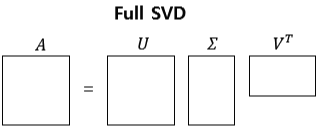

여기서 Singular Value($\Sigma$)는 항상 양수이기에 루트를 이용해 다음과 같이 둘로 분리할 수 있다.

$$R = U\sqrt{\Sigma}\sqrt{\Sigma}^T V^T$$

위 식에서 $U\sqrt{\Sigma}$를 $Q$, $\sqrt{\Sigma}^T VT$를 $P$로 가져가면 SVD를 통해 $R = PQ^T$로 표현할 수 있다.

여기서 중요한점은 모든 $P, Q$를 사용하지 않고 $\Sigma$의 대각 성분인 특이치 값이 가장 큰 $k$개의 특이치를 사용하여 (Truncated SVD)로 $R$을 만드는 것이다. 이렇게 채워진 $R$을 이용해 Imputation을 진행한다.

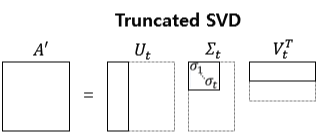

- U^ 는 U에서 가장 값이 큰 k개의 특이치에 대응하는 k개의 성분만을 남긴 m×k 크기의 행렬

- Σ^ 는 가장 값이 큰 k개의 특이치에 대응하는 k개의 성분만을 남긴 k×k 크기의 대각 행렬

- V^ 는 V에서 가장 값이 큰 k개의 특이치에 대응하는 k개의 성분만을 남긴 k×n 크기의 행렬

$$\hat{U} \hat{\Sigma} \hat{V}^T =  \hat{R} \approx R$$

하지만 평점 행렬은 대부분 희소행렬(sparse matrix)로 SVD를 바로 적용하기 힘들어 행렬 $P, Q$는 다음과 같은 모형에 대해 오차함수를 최소화하여 구하게 된다.

$$\hat{r}(u,i) = \mu + b(u) + b(i) + q(i)^Tp(u)$$

$$\sum_{u,i \in R_{train}} \left(r(u,i) - \hat{r}(u,i) \right)^2 +
\lambda\left(b(i)^2 + b(u)^2 + ||q(i)||^2 + ||p(u)||^2\right)$$

In [ ]:
algo = surprise.SVD(n_factors=100)
cross_validate(algo, data)['test_mae'].mean()

# NMF(Non-negative matrix factorization)

SVD 대신 바로 2개의 행렬로 쪼개는 방법을 이용한 방법이다.

In [ ]:
algo = surprise.NMF(n_factors=100)
cross_validate(algo, data)["test_mae"].mean()

# test, predict

test는 다음과 같이 사용하며 모든 테스트 데이터에 대한 평점 예측을 반환한다.

In [ ]:
from surprise.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.25,
                              random_state=42)
pred = algo.test(test)
pred[:10]

predict는 예측하고 싶은 하나의 사용자와 아이템을 인자로 받아 하나의 예측값만을 반환한다.

In [ ]:
df_pivot.iloc[0, 3:10]

In [ ]:
iids = range(1000, 1007)

for iid in iids:
    uid = str(1)
    iid = str(iid)
    print(algo.predict(uid, iid))

# 모델 성능 종합

In [117]:
from surprise.model_selection import KFold

def get_metrics(algo):
    
    np.random.seed(0)
    rmse = np.zeros(3)
    mae = np.zeros(3)
    fcp = np.zeros(3)
    cv = KFold(3)

    for i, (trainset, testset) in enumerate(cv.split(data)):
        algo.fit(trainset)
        predictions = algo.test(testset)
        rmse[i] = surprise.accuracy.rmse(predictions, verbose=True)
        mae[i] = surprise.accuracy.mae(predictions, verbose=True)
        fcp[i] = surprise.accuracy.fcp(predictions, verbose=True)
    model_name = str(algo).split('.')[2]
    rmse_mean = np.mean(rmse)
    mae_mean = np.mean(mae)
    fcp_mean = np.mean(fcp)
    return pd.DataFrame({'model_name':[model_name],
             'rmse':[rmse_mean],
             'mae':[mae_mean],
             'fcp':[fcp_mean]})

In [118]:
# 베이스라인 모델

# 베이스라인 모델에 사용할 파라미터 정의
bsl_options = {
    'method' : 'als',
    'n_epochs' : 5,
    'reg_u' : 12,
    'reg_i' : 5
}

# 베이스라인 모델 생성
algo = surprise.BaselineOnly(bsl_options)
df = get_metrics(algo)
df

Estimating biases using als...
RMSE: 0.9453
MAE:  0.7488
FCP:  0.6972
Estimating biases using als...
RMSE: 0.9377
MAE:  0.7427
FCP:  0.7078
Estimating biases using als...
RMSE: 0.9500
MAE:  0.7531
FCP:  0.7014


,model_name,rmse,mae,fcp
0,baseline_only,0.94433,0.748174,0.70217


In [119]:
# MSD를 이용한 CF

sim_option = {'name':'msd'}
algo = surprise.KNNBasic(sim_option=sim_option) # 디폴트는 user-based
df = df.append(get_metrics(algo))
df

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9941
MAE:  0.7841
FCP:  0.7087
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9832
MAE:  0.7760
FCP:  0.7149
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9926
MAE:  0.7857
FCP:  0.7105


,model_name,rmse,mae,fcp
0,baseline_only,0.944330,0.748174,0.702170
0,knns,0.989935,0.781954,0.711397


In [120]:
df.loc[df.model_name == 'knns', ('model_name')] = 'msd'
df

,model_name,rmse,mae,fcp
0,baseline_only,0.944330,0.748174,0.702170
0,msd,0.989935,0.781954,0.711397


In [121]:
# 코사인 유사도를 이용한 CF

sim_option = {'name':'cosine'}
algo = surprise.KNNBasic(sim_option=sim_option) # 디폴트는 user-based
df = df.append(get_metrics(algo))
df.loc[df.model_name == 'knns', ('model_name')] = 'cosine'
df

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9941
MAE:  0.7841
FCP:  0.7087
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9832
MAE:  0.7760
FCP:  0.7149
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9926
MAE:  0.7857
FCP:  0.7105


,model_name,rmse,mae,fcp
0,baseline_only,0.944330,0.748174,0.702170
0,msd,0.989935,0.781954,0.711397
0,cosine,0.989935,0.781954,0.711397


In [122]:
# 피어슨 베이스라인

sim_options = {'name': 'pearson_baseline'}
algo = surprise.KNNBasic(sim_options=sim_options)
df = df.append(get_metrics(algo))
df.loc[df.model_name == 'knns', ('model_name')] = 'pearson'
df

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0162
MAE:  0.8022
FCP:  0.7121
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0034
MAE:  0.7930
FCP:  0.7177
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0136
MAE:  0.8032
FCP:  0.7139


,model_name,rmse,mae,fcp
0,baseline_only,0.944330,0.748174,0.702170
0,msd,0.989935,0.781954,0.711397
0,cosine,0.989935,0.781954,0.711397
0,pearson,1.011054,0.799487,0.714558


In [123]:
# SVD

algo = surprise.SVD(n_factors=100)
df = df.append(get_metrics(algo))
df

RMSE: 0.9480
MAE:  0.7480
FCP:  0.6910
RMSE: 0.9392
MAE:  0.7420
FCP:  0.7032
RMSE: 0.9518
MAE:  0.7510
FCP:  0.6949


,model_name,rmse,mae,fcp
0,baseline_only,0.944330,0.748174,0.702170
0,msd,0.989935,0.781954,0.711397
0,cosine,0.989935,0.781954,0.711397
0,pearson,1.011054,0.799487,0.714558
0,matrix_factorization,0.946315,0.747009,0.696355


In [124]:
df.loc[df.model_name == 'matrix_factorization', ('model_name')] = 'SVD'

In [126]:
# NMF

algo = surprise.NMF(n_factors=100)
df = df.append(get_metrics(algo))
df

RMSE: 1.1017
MAE:  0.8391
FCP:  0.6910
RMSE: 1.0966
MAE:  0.8342
FCP:  0.6978
RMSE: 1.1002
MAE:  0.8350
FCP:  0.6965


,model_name,rmse,mae,fcp
0,baseline_only,0.944330,0.748174,0.702170
0,msd,0.989935,0.781954,0.711397
0,cosine,0.989935,0.781954,0.711397
0,pearson,1.011054,0.799487,0.714558
0,SVD,0.946315,0.747009,0.696355
0,matrix_factorization,1.099537,0.836117,0.695118


In [127]:
df.loc[df.model_name == 'matrix_factorization', ('model_name')] = 'NMF'
df

,model_name,rmse,mae,fcp
0,baseline_only,0.944330,0.748174,0.702170
0,msd,0.989935,0.781954,0.711397
0,cosine,0.989935,0.781954,0.711397
0,pearson,1.011054,0.799487,0.714558
0,SVD,0.946315,0.747009,0.696355
0,NMF,1.099537,0.836117,0.695118


In [129]:
df.sort_values(by='rmse', ascending=False)

,model_name,rmse,mae,fcp
0,NMF,1.099537,0.836117,0.695118
0,pearson,1.011054,0.799487,0.714558
0,msd,0.989935,0.781954,0.711397
0,cosine,0.989935,0.781954,0.711397
0,SVD,0.946315,0.747009,0.696355
0,baseline_only,0.944330,0.748174,0.702170
